##**1.a. Data Pre-Porcessing**

Clean the data using your knowledge of the course. For context, you will create in later questions a model that predicts a household’s proportion of income spent on total personal insurance premiums and retirement/pension contributions and apply a clustering algorithm over the full data.

##**Import Libraries & Download the Datasets**

In [18]:
# Basic packages
import numpy as np
from functools import reduce
from io import BytesIO
import gdown

# Data handling
import pandas as pd
import polars as pl
from scipy.stats import zscore
import shap

# Scikit-learn
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, export_graphviz
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, BaggingRegressor, RandomForestRegressor
from sklearn.datasets import make_classification
from sklearn.model_selection import GridSearchCV, train_test_split, StratifiedKFold
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import VarianceThreshold
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split, GridSearchCV, RepeatedKFold
from sklearn.linear_model import ElasticNet
from sklearn.cluster import AgglomerativeClustering, KMeans, SpectralClustering
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.decomposition import PCA
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from yellowbrick.cluster.elbow import kelbow_visualizer
from sklearn.metrics import mean_squared_error, r2_score

# UMAP
import umap

# XGBoost
from xgboost import XGBRegressor, XGBClassifier

# Shap
import shap
shap.initjs() # Import Java engine.

# Plotting
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from IPython.display import Image
import pydotplus
from tqdm import tqdm
%matplotlib inline

In [19]:
!pip install -q gdown
!gdown --folder https://drive.google.com/drive/folders/1rwgSER66b-YjwIh9GaMx6fy0RPmKHQES?usp=sharing

Retrieving folder contents
Processing file 1X66YCqLPSXKeq4eYVpzgmVw_LAaJT3R7 DemoStats.csv
Processing file 1TDIqet30lGXahay5VKZ9MTkT6LRLdoBD HouseholdSpend.csv
Retrieving folder contents completed
Building directory structure
Building directory structure completed
Failed to retrieve file url:

	Too many users have viewed or downloaded this file recently. Please
	try accessing the file again later. If the file you are trying to
	access is particularly large or is shared with many people, it may
	take up to 24 hours to be able to view or download the file. If you
	still can't access a file after 24 hours, contact your domain
	administrator.

You may still be able to access the file from the browser:

	https://drive.google.com/uc?id=1X66YCqLPSXKeq4eYVpzgmVw_LAaJT3R7

but Gdown can't. Please check connections and permissions.


## **Pre-Processing HouseholdSpend.csv**

In [21]:
# Read the CSV with escaped space in path
household_df = pl.read_csv("Coursework Data/HouseholdSpend.csv")

# Get size of dataset
print("The size of household_df is \n", household_df.shape)

# Show first 5 rows
household_df.head()

FileNotFoundError: No such file or directory (os error 2): Coursework Data/HouseholdSpend.csv

In [ ]:
# Describe the dataset
household_df.describe()

statistic,CODE,GEO,HSBASHHD,HSHNIAGG,HSAGDISPIN,HSAGDISCIN,HSTT001,HSTE001,HSTX001,HSTC001,HSSH001S,HSFD001S,HSHO001S,HSHC001S,HSHF001S,HSTR001S,HSRE001S,HSPC001S,HSCL001S,HSED002S,HSRO001S,HSTA001S,HSGC001S,HSME001S,HSEP001S,HSMG001S,HSTE001ZBS,HSWH002S,HSWH028S,HSWH040S,HSWH041S,HSWH042S,HSSH001,HSSH002,HSSH003,HSSH004,…,HSTR002,HSTR003,HSTR004,HSTR005,HSTR006,HSTR007,HSTR008,HSTR009,HSTR058,HSTR010,HSTR011,HSTR012,HSTR014M,HSTR015,HSTR020,HSTR030,HSTR031,HSTR032,HSTR033,HSTR034,HSTR035,HSTR036,HSTR037,HSTR038,HSTR039,HSTR040,HSTR041,HSTR050,HSTR051,HSTR052,HSTR053,HSTR054,HSTR055,HSTR056,HSTR056A,HSTR056B,HSTR057
str,str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""count""","""868970""","""868970""",868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,…,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0
"""null_count""","""0""","""0""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,…,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""mean""",null,null,18.432629,2.2534e6,1.7170e6,1.2342e6,2.4008e6,2.1917e6,421335.834661,1.6065e6,388812.651163,278016.994627,111401.557243,109343.827301,76103.411113,271135.371662,87929.804561,45315.650319,70798.452452,34398.504565,3570.867859,70468.350013,25849.158365,33310.372386,115213.19111,48732.91062,209040.481816,67544.21004,4806.924846,112565.256385,15089.24985,9034.840695,388812.651163,303764.492909,89251.190609,88053.450315,…,236398.761036,118477.006209,114562.677761,14888.288571,8607.895903,91066.493288,188.957063,83.539013,105.41805,3725.371385,3469.552047,2092.59778,1376.954267,255.819338,1504.664209,116417.090618,3287.664753,10103.061471,12676.188385,18214.142317,100.530695,63415.559732,2639.560863,4612.181943,1368.200459,379.01064,989.189819,34736.610626,5995.306708,2258.469958,915.416319,23038.220756,71.1409,1322.434304,831.592595,490.84171,1135.621681
"""std""",null,null,69.379951,8.2787e6,6.3276e6,4.6340e6,9.1329e6,8.0562e6,1.5969e6,5.9255e6,1.3661e6,1.0471e6,420881.63654,429642.774397,290959.592849,1.0751e6,327376.60947,163377.943862,249311.269506,114999.916794,14386.745375,264786.580294,94955.831503,127397.296924,431645.982804,206454.726959,1.2713e6,341440.420828,40531.631801,898861.389623,51492.602769,35858.838458,1.3661e6,1.0270e6,292325.224526,287942.333453,…,990960.632583,507452.95803,494184.487741,58848.760548,45895.371562,398856.15598,794.022208,358.55285,497.256289,14112.764792,13213.369738,8173.498909,5705.767025,1422.161917,5673.303299,486744.921092,14400.182837,39378.141535,60281.31644,71889.568827,615.785308,284702.777168,13567.714202,14917.235034,5725.037991,2091.296014,3882.026395,101629.434794,19414.670337,7613.821326,5037.673958,71509.135272,257.018871,6638.799848,5076.885882,2097.649493,4203.801021
"""min""","""A0A0A0""","""FSALDU""",0.0,0.0,0.0,0.0,-24249.492537,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.4599e7,0.0,0.0,-1.6806e7,-26676.98553,-204380.698719,0.0,0.0,0.0,0.0,…,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.

In [ ]:
# drop the main cateogry columns the main category columns based on the hierarchical format in metadata and maintain the most granular level of information
columns_to_drop = ['CODE', 'GEO', 'HSAGDISPIN', 'HSAGDISCIN', 'HSTT001', 'HSTE001', 'HSTC001', 'HSMG001S','HSTE001ZBS','HSWH042S','HSSH001','HSSH002','HSSH003','HSSH004','HSSH010',
                   'HSSH016','HSSH012','HSSH012B','HSSH030','HSSH031','HSSH032','HSSH033','HSSH034','HSSH035','HSSH036','HSSH037','HSSH040','HSSH041','HSSH046','HSSH047','HSSH050','HSFD001',
                   'HSFD990','HSFD991','HSHO001','HSHO003','HSHO010','HSHO014','HSHO018','HSCC001','HSCC002','HSCC013','HSCS001','HSCS003','HSCS011','HSHC001','HSHC002','HSHC004','HSHC005',
                   'HSHC006','HSHC010','HSHC022','HSHF001','HSHF002','HSHF005','HSHE001','HSHE002','HSHE010','HSHE011','HSHE012','HSHE020','HSTR001','HSTR002','HSTR003','HSTR004','HSTR008',
                   'HSTR010','HSTR011','HSTR030','HSTR039','HSTR050','HSTR056'
]

household_df = household_df.drop(columns_to_drop)

# check the size of updated dataset
print("The size of household_df is \n", household_df.shape)

The size of household_df is 
 (868970, 174)


In [ ]:
# Replace negative data with null values
household_df = household_df.with_columns([
    pl.when(household_df[col] >= 0).then(household_df[col]).otherwise(None).alias(col)
    for col in household_df.columns
])

In [ ]:
household_df.describe()

statistic,HSBASHHD,HSHNIAGG,HSTX001,HSSH001S,HSFD001S,HSHO001S,HSHC001S,HSHF001S,HSTR001S,HSRE001S,HSPC001S,HSCL001S,HSED002S,HSRO001S,HSTA001S,HSGC001S,HSME001S,HSEP001S,HSWH002S,HSWH028S,HSWH040S,HSWH041S,HSSH053,HSSH054,HSSH005,HSSH006,HSSH007,HSSH011,HSSH014,HSSH013,HSSH015,HSSH017,HSSH018,HSSH019,HSSH021,HSSH020,…,HSHE011A,HSHE011B,HSHE031,HSHE012M,HSHE032,HSHE013,HSHE015,HSHE016,HSHE021,HSHE023,HSTR005,HSTR006,HSTR007,HSTR009,HSTR058,HSTR012,HSTR014M,HSTR015,HSTR020,HSTR031,HSTR032,HSTR033,HSTR034,HSTR035,HSTR036,HSTR037,HSTR038,HSTR040,HSTR041,HSTR051,HSTR052,HSTR053,HSTR054,HSTR055,HSTR056A,HSTR056B,HSTR057
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""count""",868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,613112.0,853534.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,…,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0
"""null_count""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,255858.0,15436.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,…,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""mean""",18.432629,2.2534e6,421335.834661,388812.651163,278016.994627,111401.557243,109343.827301,76103.411113,271135.371662,87929.804561,45315.650319,70798.452452,34398.504565,3570.867859,70468.350013,25849.158365,33310.372386,115213.19111,67544.21004,4806.924846,223246.682916,15368.240572,87440.075786,613.374529,183.700577,828.596641,185.443075,106828.484285,36408.179557,6526.956914,8275.463932,13257.931077,824.216363,1072.09477,441.244565,393.496289,…,625.514775,1051.235874,942.213922,965.192576,474.349597,3900.212489,2200.824293,6095.906893,2180.972474,3817.392547,14888.288571,8607.895903,91066.493288,83.539013,105.41805,2092.59778,1376.954267,255.819338,1504.664209,3287.664753,10103.061471,12676.188385,18214.142317,100.530695,63415.559732,2639.560863,4612.181943,379.01064,989.189819,5995.306708,2258.469958,915.416319,23038.220756,71.1409,831.592595,490.84171,1135.621681
"""std""",69.379951,8.2787e6,1.5969e6,1.3661e6,1.0471e6,420881.63654,429642.774397,290959.592849,1.0751e6,327376.60947,163377.943862,249311.269506,114999.916794,14386.745375,264786.580294,94955.831503,127397.296924,431645.982804,341440.420828,40531.631801,1.0130e6,51913.881577,285952.018412,2371.573942,993.000184,3140.51177,1269.469849,397620.722531,149038.603917,37839.184464,37847.3863,48688.897598,3850.335045,4300.894305,1957.281708,2180.233907,…,3765.198026,6358.222641,5591.277873,6589.261277,3586.021082,16401.824619,9527.201342,27469.24435,14411.62878,13733.285414,58848.760548,45895.371562,398856.15598,358.55285,497.256289,8173.498909,5705.767025,1422.161917,5673.303299,14400.182837,39378.141535,60281.31644,71889.568827,615.785308,284702.777168,13567.714202,14917.235034,2091.296014,3882.026395,19414.670337,7613.821326,5037.673958,71509.135272,257.018871,5076.885882,2097.649493,4203.801021
"""min""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,…,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,

In [ ]:
# display the columns with null values and the percentage of null

# Count nulls for all columns
null_counts_df = (household_df.null_count() / 868970.0) * 100

# Convert null_counts_df to dictionary format
household_df_columns_with_nulls = {
    col: null_counts_df[0, i] for i, col in enumerate(household_df.columns) if null_counts_df[0, i] > 0
}

# Print only if there are null values
if household_df_columns_with_nulls:
    print(household_df_columns_with_nulls)
else:
    print("No columns with null values.")

{'HSWH040S': 29.443824297731798, 'HSWH041S': 1.7763559156242448}


As the percentage of null values in the column below is less than 5%, the null values will be replaced by median:

*   'HSWH041S': 1.7763559156242448

We can drop the column 'HSWH040S' since around 30% of its values are null:

*  'HSWH040S': 29.443824297731798        Net purchase price of owned residences




In [ ]:
# Replace null values with median for specific columns
household_df = household_df.with_columns([
    pl.col('HSWH041S').fill_null(pl.col('HSWH041S').median())
])

# Remove columns with too many null values
household_df = household_df.drop('HSWH040S')

In [ ]:
household_df.describe()

statistic,HSBASHHD,HSHNIAGG,HSTX001,HSSH001S,HSFD001S,HSHO001S,HSHC001S,HSHF001S,HSTR001S,HSRE001S,HSPC001S,HSCL001S,HSED002S,HSRO001S,HSTA001S,HSGC001S,HSME001S,HSEP001S,HSWH002S,HSWH028S,HSWH041S,HSSH053,HSSH054,HSSH005,HSSH006,HSSH007,HSSH011,HSSH014,HSSH013,HSSH015,HSSH017,HSSH018,HSSH019,HSSH021,HSSH020,HSSH022,…,HSHE011A,HSHE011B,HSHE031,HSHE012M,HSHE032,HSHE013,HSHE015,HSHE016,HSHE021,HSHE023,HSTR005,HSTR006,HSTR007,HSTR009,HSTR058,HSTR012,HSTR014M,HSTR015,HSTR020,HSTR031,HSTR032,HSTR033,HSTR034,HSTR035,HSTR036,HSTR037,HSTR038,HSTR040,HSTR041,HSTR051,HSTR052,HSTR053,HSTR054,HSTR055,HSTR056A,HSTR056B,HSTR057
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""count""",868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,…,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0
"""null_count""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,…,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""mean""",18.432629,2.2534e6,421335.834661,388812.651163,278016.994627,111401.557243,109343.827301,76103.411113,271135.371662,87929.804561,45315.650319,70798.452452,34398.504565,3570.867859,70468.350013,25849.158365,33310.372386,115213.19111,67544.21004,4806.924846,15201.459853,87440.075786,613.374529,183.700577,828.596641,185.443075,106828.484285,36408.179557,6526.956914,8275.463932,13257.931077,824.216363,1072.09477,441.244565,393.496289,3005.398689,…,625.514775,1051.235874,942.213922,965.192576,474.349597,3900.212489,2200.824293,6095.906893,2180.972474,3817.392547,14888.288571,8607.895903,91066.493288,83.539013,105.41805,2092.59778,1376.954267,255.819338,1504.664209,3287.664753,10103.061471,12676.188385,18214.142317,100.530695,63415.559732,2639.560863,4612.181943,379.01064,989.189819,5995.306708,2258.469958,915.416319,23038.220756,71.1409,831.592595,490.84171,1135.621681
"""std""",69.379951,8.2787e6,1.5969e6,1.3661e6,1.0471e6,420881.63654,429642.774397,290959.592849,1.0751e6,327376.60947,163377.943862,249311.269506,114999.916794,14386.745375,264786.580294,94955.831503,127397.296924,431645.982804,341440.420828,40531.631801,51465.672279,285952.018412,2371.573942,993.000184,3140.51177,1269.469849,397620.722531,149038.603917,37839.184464,37847.3863,48688.897598,3850.335045,4300.894305,1957.281708,2180.233907,12340.85786,…,3765.198026,6358.222641,5591.277873,6589.261277,3586.021082,16401.824619,9527.201342,27469.24435,14411.62878,13733.285414,58848.760548,45895.371562,398856.15598,358.55285,497.256289,8173.498909,5705.767025,1422.161917,5673.303299,14400.182837,39378.141535,60281.31644,71889.568827,615.785308,284702.777168,13567.714202,14917.235034,2091.296014,3882.026395,19414.670337,7613.821326,5037.673958,71509.135272,257.018871,5076.885882,2097.649493,4203.801021
"""min""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,…,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0

In [ ]:
# Use z_sscore to identify and remove outliers

# Assume household_df is already a NumPy array
column_names = household_df.columns
household_df_np = household_df.to_numpy()

# Calculate z-scores
z_scores = np.abs(zscore(household_df_np, nan_policy='omit'))

# Count outliers
outlier_counts = (z_scores > 3).sum(axis=0)
n_rows = household_df_np.shape[0]
outlier_percentages = outlier_counts / n_rows

# Identify columns to drop
threshold = 0.05
columns_to_drop = [
    col for col, ratio in zip(column_names, outlier_percentages) if ratio > threshold
]

print("Columns to drop due to outliers:", columns_to_drop)


Columns to drop due to outliers: []


In [ ]:
# Use Winsorization to replcase outliers

# List to hold columns to winsorize
for col in household_df.columns:
    # Convert column to NumPy array
    values = household_df[col].to_numpy()

    # Calculate Q1, Q3, and IQR
    q1 = np.percentile(values, 25)
    q3 = np.percentile(values, 75)
    iqr = q3 - q1

    # Define IQR bounds
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr

    # Replace values outside bounds with boundaries (winsorization)
    winsorized_values = np.clip(values, lower_bound, upper_bound)

    # Update column in the DataFrame
    household_df = household_df.with_columns(
        pl.Series(name=col, values=winsorized_values)
    )

print("Winsorization completed.")
print("New shape:", household_df.shape)

Winsorization completed.
New shape: (868970, 173)


## **Processing DemoStats.csv**

In [ ]:
# Read the CSV with escaped space in path
demoStats_df = pl.read_csv("Coursework Data/DemoStats.csv")

# size of dataset
print("The size of DemoStats is \n", demoStats_df.shape)

# Show first 5 rows
demoStats_df.head()

The size of DemoStats is 
 (868970, 736)


CODE,GEO,ECYASQKM,ECYALSQKM,ECYBASPOP,ECYBASHHD,ECYBASHPOP,ECYBAS12P,ECYBAS15P,ECYBAS18P,ECYBAS19P,ECYBAS12HP,ECYBAS15HP,ECYBAS18HP,ECYBAS19HP,ECYBASTNGH,ECYBASADUH,ECYBASCF,ECYBASCFH,ECYBASKID,ECYBASLF,ECYPTAPOP,ECYPTA_0_4,ECYPTA_5_9,ECYPTA1014,ECYPTA1519,ECYPTA2024,ECYPTA2529,ECYPTA3034,ECYPTA3539,ECYPTA4044,ECYPTA4549,ECYPTA5054,ECYPTA5559,ECYPTA6064,ECYPTA6569,ECYPTA7074,…,ECYRIMINDI,ECYRIMNEPA,ECYRIMPAKI,ECYRIMSRI,ECYRIMSASO,ECYRIMOCE,ECYRIMAUSS,ECYRIMOCEO,ECYPIMHPOP,ECYPIMNI,ECYPIMIM,ECYPIMP01,ECYPIM0110,ECYPIM1115,ECYPIM1621,ECYPIM22CY,ECYPIMNPER,ECYAIMHPOP,ECYAIMNI,ECYAIMIM,ECYAIM_0_5,ECYAIM_514,ECYAIM1524,ECYAIM2544,ECYAIM45P,ECYAIMNPER,ECYGENHPOP,ECYGEN1GEN,ECYGEN2GEN,ECYGEN3GEN,ECYTCAHPOP,ECYTCACIT,ECYTCA_U18,ECYTCA_18P,ECYNCANCIT,ECYNCA_U18,ECYNCA_18P
str,str,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,…,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64
"""A0A0A0""","""FSALDU""",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
"""A0A1A0""","""FSALDU""",0,0,55,33,55,55,55,55,55,55,55,55,55,0,20,17,17,4,24,55,0,0,0,0,0,0,0,0,0,4,2,7,7,15,14,…,0,0,0,0,0,0,0,0,55,55,0,0,0,0,0,0,0,55,55,0,0,0,0,0,0,0,55,0,0,55,55,55,0,55,0,0,0
"""A0A1B0""","""FSALDU""",0,0,588,243,588,561,512,475,475,513,512,475,475,38,280,172,168,136,264,588,15,12,49,37,19,37,8,35,29,45,30,57,39,43,59,…,0,0,0,0,0,0,0,0,588,577,11,3,2,0,0,6,0,588,577,11,0,1,1,5,4,0,588,11,14,563,588,587,113,474,1,0,1
"""A0A1C0""","""FSALDU""",0,0,1793,709,1791,1548,1465,1405,1395,1495,1463,1408,1396,87,935,560,543,491,958,1793,98,127,103,79,90,81,110,111,116,132,107,140,138,148,91,…,0,0,0,2,0,0,0,0,1791,1741,40,21,2,0,0,17,10,1791,1741,40,4,2,21,12,1,10,1791,50,32,1709,1791,1776,380,1396,15,3,12
"""A0A1E0""","""FSALDU""",0,0,452,176,449,415,389,357,357,389,386,354,354,35,211,132,130,121,200,452,20,16,27,32,24,18,27,32,21,17,27,21,48,29,35,…,0,0,0,0,0,0,0,0,449,439,9,5,2,0,0,2,1,449,439,9,2,0,4,3,0,1,449,10,14,425,449,446,95,351,3,0,3


In [ ]:
# Describe the dataset
demoStats_df.describe()

In [ ]:
# Find columns with string data type
string_columns = [col for col, dtype in zip(demoStats_df.columns, demoStats_df.dtypes) if dtype == pl.String]

print("Columns with string data types:", string_columns)

Columns with string data types: ['CODE', 'GEO', 'ECYPTAMED', 'ECYPMAMED', 'ECYPFAMED', 'ECYHTAMED', 'ECYHMAMED', 'ECYHFAMED', 'ECYMTNMED']


In [ ]:
# display the data of string columns
demoStats_df.select(string_columns)

CODE,GEO,ECYPTAMED,ECYPMAMED,ECYPFAMED,ECYHTAMED,ECYHMAMED,ECYHFAMED,ECYMTNMED
str,str,str,str,str,str,str,str,str
"""A0A0A0""","""FSALDU""","""NA""","""NA""","""NA""","""NA""","""NA""","""NA""","""NA"""
"""A0A1A0""","""FSALDU""","""67.6""","""67.3""","""68""","""67.6""","""67.3""","""68""","""69.8"""
"""A0A1B0""","""FSALDU""","""51.3""","""50.2""","""69.4""","""51.3""","""50.2""","""69.4""","""62"""
"""A0A1C0""","""FSALDU""","""44.2""","""43.5""","""46.5""","""44.2""","""43.5""","""46.4""","""57.3"""
"""A0A1E0""","""FSALDU""","""47.8""","""42.7""","""60""","""47.3""","""42.1""","""60""","""61.8"""
…,…,…,…,…,…,…,…,…
"""Y1A6W1""","""FSALDU""","""36.4""","""34.2""","""37.6""","""36.4""","""34.2""","""37.6""","""46.7"""
"""Y1A7A1""","""FSALDU""","""41.5""","""41.7""","""41.3""","""41.3""","""41.4""","""41.2""","""54"""
"""Y1A7A2""","""FSALDU""","""40""","""39.4""","""40.6""","""39.9""","""39.3""","""40.5""","""53"""


****The data of string columns are floating numbers (age).
We can convert them into numbers.


In [ ]:
# drop "CODE" and	"GEO" columns
demoStats_df = demoStats_df.drop('CODE', 'GEO')

# get the list of variables with string type columns
string_columns_updated = ['ECYPTAMED', 'ECYPMAMED', 'ECYPFAMED', 'ECYHTAMED', 'ECYHMAMED', 'ECYHFAMED', 'ECYMTNMED']

# Replace "NA" with null and cast the column to float64
demoStats_df = demoStats_df.with_columns([
    pl.when(pl.col(col) == "NA").then(None)
    .otherwise(pl.col(col))
    .cast(pl.Float64)  # Convert to float64
    .alias(col)
    for col in string_columns_updated
])

In [ ]:
# cast string data to float64
demoStats_df = demoStats_df.with_columns([
    pl.col(col).cast(pl.Float64) if demoStats_df[col].dtype == pl.String else pl.col(col)
    for col in demoStats_df.columns
])

In [ ]:
# display the columns with null values and their number of null
# Count nulls for all columns
null_counts_df = (demoStats_df.null_count() / 868970.0) * 100

# Convert null_counts_df to dictionary format
demoStats_df_columns_with_nulls = {
    col: null_counts_df[0, i] for i, col in enumerate(demoStats_df.columns) if null_counts_df[0, i] > 0
}

# Print only if there are null values
if demoStats_df_columns_with_nulls:
    print(demoStats_df_columns_with_nulls)
else:
    print("No columns with null values.")

{'ECYPTAMED': 10.064674269537498, 'ECYPMAMED': 11.09865703073754, 'ECYPFAMED': 15.171639987571492, 'ECYHTAMED': 10.66883781948744, 'ECYHMAMED': 11.703280895773156, 'ECYHFAMED': 15.86936257868511, 'ECYMTNMED': 10.66883781948744}


The percentage of null values for the columns is between 10% to 15%.
we can do imputation with median.

In [ ]:
# Replace nulls with median for each column in the dictionary
demoStats_df = demoStats_df.with_columns([
    pl.col(col).fill_null(demoStats_df[col].median()) for col in demoStats_df_columns_with_nulls
])

In [ ]:
# check for any negative values
negative_columns = [col for col in demoStats_df.columns if demoStats_df[col].min() < 0]

if negative_columns:
    print("Columns with negative values:")
    print(negative_columns)
else:
    print("No columns contain negative values.")

No columns contain negative values.


In [ ]:
# drop columns which are highly correlated
demoStats_columns_to_drop = ['ECYPTAPOP','ECYPTA_0_4','ECYPTA_5_9','ECYPTA1014','ECYPTA1519','ECYPTA2024','ECYPTA2529','ECYPTA3034','ECYPTA3539','ECYPTA4044','ECYPTA4549','ECYPTA5054',
                                 'ECYPTA5559','ECYPTA6064','ECYPTA6569','ECYPTA7074','ECYPTA7579','ECYPTA8084','ECYPTA85P','ECYPTAAVG','ECYPTAMED','ECYPMAPOP','ECYPMAAVG','ECYPMAMED','ECYPFAPOP',
                                 'ECYPFAAVG','ECYPFAMED','ECYHTAHPOP','ECYHTA_0_4','ECYHTA_5_9','ECYHTA1014','ECYHTA1519','ECYHTA2024','ECYHTA2529','ECYHTA3034','ECYHTA3539','ECYHTA4044','ECYHTA4549',
                                 'ECYHTA5054','ECYHTA5559','ECYHTA6064','ECYHTA6569','ECYHTA7074','ECYHTA7579','ECYHTA8084','ECYHTA85P','ECYHTAAVG','ECYHTAMED','ECYHMAHPOP','ECYHMAAVG','ECYHMAMED',
                                 'ECYHFAHPOP','ECYHFAAVG','ECYHFAMED','ECYMTNHHD','ECYMTNAVG','ECYMTNMED','ECYHSZHHD','ECYHSZAVG','ECYHTYHHD','ECYHTYFHT','ECYHTY1FH','ECYHTYNFH','ECYHTYN65A','ECYMARHP15',
                                 'ECYMARMCL','ECYMARNMCL','ECYCFSCF','ECYCFSC','ECYCFSM','ECYCFSCL','ECYCFSLP','ECYHFSCF','ECYHFSC','ECYHFSM','ECYHFSCL','ECYHFSLP','ECYHFSWC','ECYCHAKIDS','ECYCHACFCH',
                                 'ECYCHAFHCH','ECYCHAHHCH','ECYMOBHPOP','ECYTENHHD','ECYPOCHHD','ECYSTYHHD','ECYSTYHOUS','ECYSTYAPT','ECYSTYOTHR','ECYCDOHHD','ECYCDOCO','ECYCDONC','ECYHRIHHD','ECYHRI100P',
                                 'ECYHRIAVG','ECYHRIMED','ECYHRIAGG','ECYHNIHHD','ECYHNI100P','ECYHNIAVG','ECYHNIMED','ECYHNIAGG','ECYPNIHP15','ECYPNIAVG','ECYEDUHP15','ECYEDUUD','ECYEDAHPWK','ECYEDANCDD',
                                 'ECYEDAHSCE','ECYEDAATCD','ECYEDACOLL','ECYEDAUDBB','ECYEDAUD','ECYEDAUDBD','ECYEDAUDBP','ECYACTHPL','ECYACTINLF','ECYCWHPL','ECYCWT','ECYOCCHPL','ECYOCCINLF','ECYOCCALL',
                                 'ECYINDHPL','ECYINDINLF','ECYINDALL','ECYPOWHPL','ECYPOWINLF','ECYPOWEMP','ECYTRAHPL','ECYTRAALL','ECYRELHPOP','ECYRELCHR','ECYVISHPOP','ECYVISVM','ECYAIDHPOP','ECYKNOHPOP',
                                 'ECYMOTHPOP','ECYMOTSING','ECYMOTNOFF','ECYMOTMULT','ECYHOMHPOP','ECYHOMSING','ECYHOMNOFF','ECYHOMMULT','ECYTIMHPOP','ECYTIMNI','ECYTIMIMGT','ECYTIMAM','ECYTIMNAM','ECYTIMCAM',
                                 'ECYTIMCB','ECYTIMSAM','ECYTIMEU','ECYTIMWEU','ECYTIMEEU','ECYTIMNEU','ECYTIMSEU','ECYTIMAF','ECYTIMWAF','ECYTIMEAF','ECYTIMCAF','ECYTIMNAF','ECYTIMSAF','ECYTIMA','ECYTIMWCA',
                                 'ECYTIMEA','ECYTIMSEA','ECYTIMSA','ECYTIMOCE','ECYRIMHPOP','ECYRIMRIM','ECYRIMAM','ECYRIMCAM','ECYRIMCB','ECYRIMSAM','ECYRIMEU','ECYRIMWEU','ECYRIMEEU','ECYRIMNEU','ECYRIMAF',
                                 'ECYRIMWAF','ECYRIMEAF','ECYRIMCAF','ECYRIMNAF','ECYRIMA','ECYRIMWCM','ECYRIMEA','ECYRIMSEA','ECYRIMSAS','ECYRIMOCE','ECYPIMHPOP','ECYPIMIM','ECYAIMHPOP','ECYAIMIM','ECYGENHPOP',
                                 'ECYTCAHPOP','ECYTCACIT','ECYNCANCIT']

demoStats_df = demoStats_df.drop(demoStats_columns_to_drop)

In [ ]:
# List to hold columns to winsorize
for col in demoStats_df.columns:
    # Convert column to NumPy array
    values = demoStats_df[col].to_numpy()

    # Calculate Q1, Q3, and IQR
    q1 = np.percentile(values, 25)
    q3 = np.percentile(values, 75)
    iqr = q3 - q1

    # Define IQR bounds
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr

    # Replace values outside bounds with boundaries (winsorization)
    winsorized_values = np.clip(values, lower_bound, upper_bound)

    # Update column in the DataFrame
    demoStats_df = demoStats_df.with_columns(
        pl.Series(name=col, values=winsorized_values)
    )

print("Winsorization completed.")
print("New shape:", demoStats_df.shape)

Winsorization completed.
New shape: (868970, 536)


## **Join household_df and demoStats data sets**

In [ ]:
print(f"The size of household_df is {household_df.shape}\n")
print(f"The size of demoStats_df is {demoStats_df.shape}\n")

# concatenante two tables
joined_df = household_df.hstack(demoStats_df)

print(f"The size of joined_df is {joined_df.shape}\n")

The size of household_df is (868970, 173)

The size of demoStats_df is (868970, 536)

The size of joined_df is (868970, 709)



## **Sampling, Target Variable and Standardization**

In [ ]:
# Target variable
# HSEP001S: Total personal insurance premiums and retirement/pension contributions
# HSHNIAGG: Household Income
target_cols = ["HSHNIAGG", "HSEP001S"]

# the target variable is defiend as the proportion of a household’s proportion of income spent on
# total personal insurance premiums and retirement/pension contributions

# check if the zero values for "HSHNIAGG", "HSEP001S"
zero_denominator_count = (joined_df['HSHNIAGG'] == 0).sum()
print(f"Rows with HSHNIAGG == 0: {zero_denominator_count}")
zero_nominator_count = (joined_df['HSEP001S'] == 0).sum()
print(f"Rows with HSEP001S == 0: {zero_nominator_count}")

Rows with HSHNIAGG == 0: 92709
Rows with HSEP001S == 0: 92709


In [ ]:
# Sample 10% of the rows
joined_df_sampled = joined_df.sample(fraction=0.1, seed=42)
print(joined_df_sampled.shape)

(86897, 709)


In [ ]:
# drop rows with HSHNIAGG == 0
joined_df_sampled = joined_df_sampled.filter(pl.col("HSHNIAGG") != 0)

In [ ]:
# define X and y
X = joined_df_sampled.drop(target_cols)
y = joined_df_sampled['HSEP001S'] / joined_df_sampled['HSHNIAGG']

In [ ]:
print(X.shape)

(77581, 707)


In [ ]:
# Standarization of dataset
scalar = StandardScaler()
X_scaled = scalar.fit_transform(X)

In [ ]:
# Removing Multicollinearity by Dropping Highly Correlated Features
# Recreate a Pandas DataFrame from X_scaled using original column names
original_columns = X.columns
df_scaled = pd.DataFrame(X_scaled, columns=original_columns)

# Compute correlation matrix
corr_matrix = df_scaled.corr().abs()

# Upper triangle mask
upper = np.triu(corr_matrix, k=1)

# Find highly correlated columns (threshold = 0.95)
to_drop = [column for i, column in enumerate(corr_matrix.columns) if any(upper[i] > 0.95)]

print("Highly correlated columns to drop:", to_drop)

# Drop them from df_scaled
df_scaled = df_scaled.drop(columns=to_drop)

# Get back to NumPy array
print(type(X_scaled))
X_scaled = df_scaled.to_numpy()

Highly correlated columns to drop: ['HSBASHHD', 'HSTX001', 'HSSH001S', 'HSFD001S', 'HSHO001S', 'HSHC001S', 'HSHF001S', 'HSTR001S', 'HSRE001S', 'HSPC001S', 'HSCL001S', 'HSTA001S', 'HSME001S', 'HSWH041S', 'HSSH014', 'HSSH015', 'HSSH043', 'HSSH044', 'HSSH051', 'HSFD003', 'HSFD992', 'HSFD993', 'HSFD995', 'HSHO011', 'HSHO012', 'HSHO015', 'HSHO016', 'HSHO017', 'HSHO022', 'HSCS004', 'HSCS005', 'HSCS007', 'HSHC003', 'HSHC004B', 'HSHC006B', 'HSHC012', 'HSHC014', 'HSHC015', 'HSHE003', 'HSTR007', 'HSTR036', 'ECYBASPOP', 'ECYBASHHD', 'ECYBASHPOP', 'ECYBAS12P', 'ECYBAS15P', 'ECYBAS18P', 'ECYBAS19P', 'ECYBAS12HP', 'ECYBAS15HP', 'ECYBAS18HP', 'ECYBAS19HP', 'ECYBASADUH', 'ECYBASCF', 'ECYBASCFH', 'ECYBASKID', 'ECYBASLF', 'ECYPMA_0_4', 'ECYPMA_5_9', 'ECYPMA1014', 'ECYPMA1519', 'ECYPMA2024', 'ECYPMA2529', 'ECYPMA3034', 'ECYPMA3539', 'ECYPMA4044', 'ECYPMA4549', 'ECYPMA5054', 'ECYPMA5559', 'ECYPMA6064', 'ECYPMA6569', 'ECYPMA7074', 'ECYPMA7579', 'ECYPMA8084', 'ECYPFA_0_4', 'ECYPFA_5_9', 'ECYPFA1014', 'ECYPF

In [ ]:
print(f"The size of X_scaled is {X_scaled.shape}\n")

The size of X_scaled is (77581, 588)



## **1.b. K-means**
Create a K-Means clustering of the data, identifying the optimal number of clusters using both the silhouette and the elbow method. Do they agree?

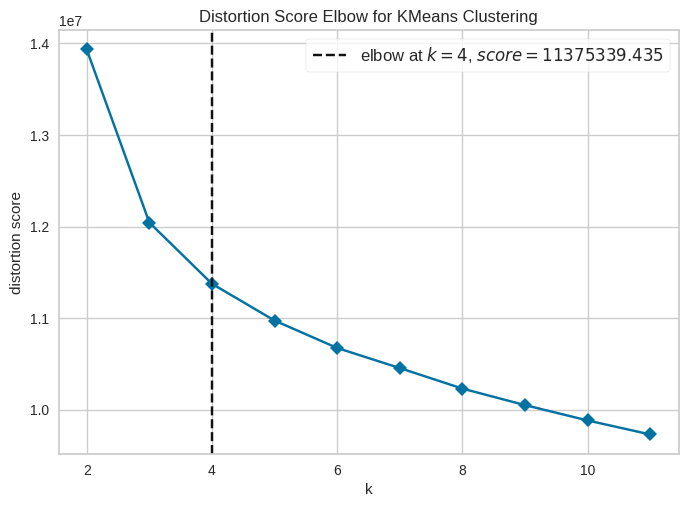

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [ ]:
# Initializing the cluster algorithm
KClusterer = KMeans(n_clusters=2, random_state=2025, verbose=0)

# Initialize the object
visualizer = KElbowVisualizer(KClusterer,
                              k=(2,12),   # Number of clusters to test (2 to 12)
                              locate_elbow=True,
                              timings=False
                             )

# Fit the data to the visualizer and show the elbow
visualizer.fit(X_scaled)
visualizer.show()

Best number of clusters by Silhouette method: 2
Maximum Silhouette Score: 0.4336


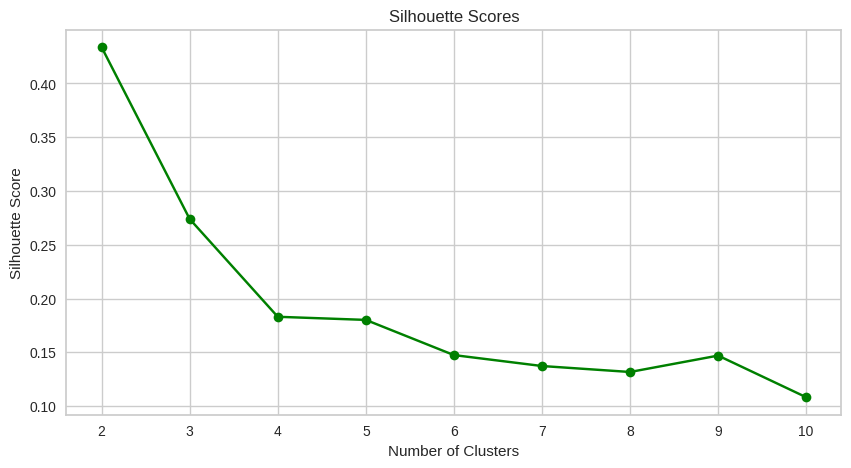

Best number of clusters by Silhouette method: 2
Silhouette Score for k=10: 0.1083


In [ ]:
K_range = range(2, 11)
silhouette_scores = []

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=2025, n_init=10)
    labels = kmeans.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, labels)
    silhouette_scores.append(score)

best_index = np.argmax(silhouette_scores)
best_k_silhouette = K_range[best_index]
max_silhouette_score = silhouette_scores[best_index]

print(f"Best number of clusters by Silhouette method: {best_k_silhouette}")
print(f"Maximum Silhouette Score: {max_silhouette_score:.4f}")

# Plot Silhouette Scores
plt.figure(figsize=(10, 5))
plt.plot(K_range, silhouette_scores, marker='o', color='green')
plt.title('Silhouette Scores')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.grid(True)
plt.show()

# Get best k from silhouette method
best_k_silhouette = K_range[np.argmax(silhouette_scores)]
print(f"Best number of clusters by Silhouette method: {best_k_silhouette}")
print(f'Silhouette Score for k={k}: {score:.4f}')

Optimal number of clusters:

*   Elbow: 4 clusters
*   Silhouette: 2 clusters

The two methods do not agree. The reason is that the silhouette technique focuses on the importance of separating clusters, typically supporting a smaller number of clusters, whereas the elbow technique concentrates on reducing intra-cluster variance, usually preferring a larger number of clusters. This difference emphasizes that identifying the ideal number of clusters may be subjective and the best choice depends on whether tightly-packed clusters or well-separated clusters are important in the context.


## **1.c. PCA**

Now we will apply a linear dimensionality reductions technique to the data.

i. Apply PCA to your data.

ii. Plot the data of the first two PCs in a scatterplot and colour the points as per the cluster labels you calculated in the previous step. What can you say about your data? Are your clusters clearly defined in the output? Interpret the first three components of your PCA output.

iii. For the first three components, calculate the average value of each component, for each cluster, so your data should look like a table with cluster number and average component value. Give a name to the clusters from this output and justify your choice.

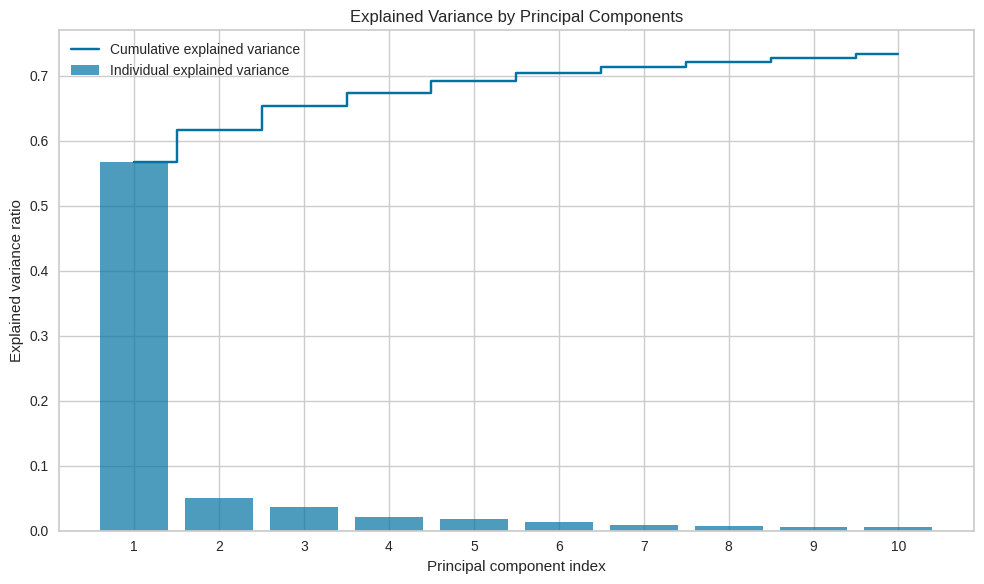

In [ ]:
# i. apply PCA to our data
pca = PCA(n_components=10)  # Starting with 10 components
pca_result = pca.fit_transform(X_scaled)

# check the explained variance ratio to understand the importance of each component
explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

# Plot the explained variance
plt.figure(figsize=(10, 6))
plt.bar(range(1, len(explained_variance) + 1), explained_variance, alpha=0.7, label='Individual explained variance')
plt.step(range(1, len(cumulative_variance) + 1), cumulative_variance, where='mid', label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.xticks(range(1, len(explained_variance) + 1))
plt.legend()
plt.title('Explained Variance by Principal Components')
plt.tight_layout()
plt.show()


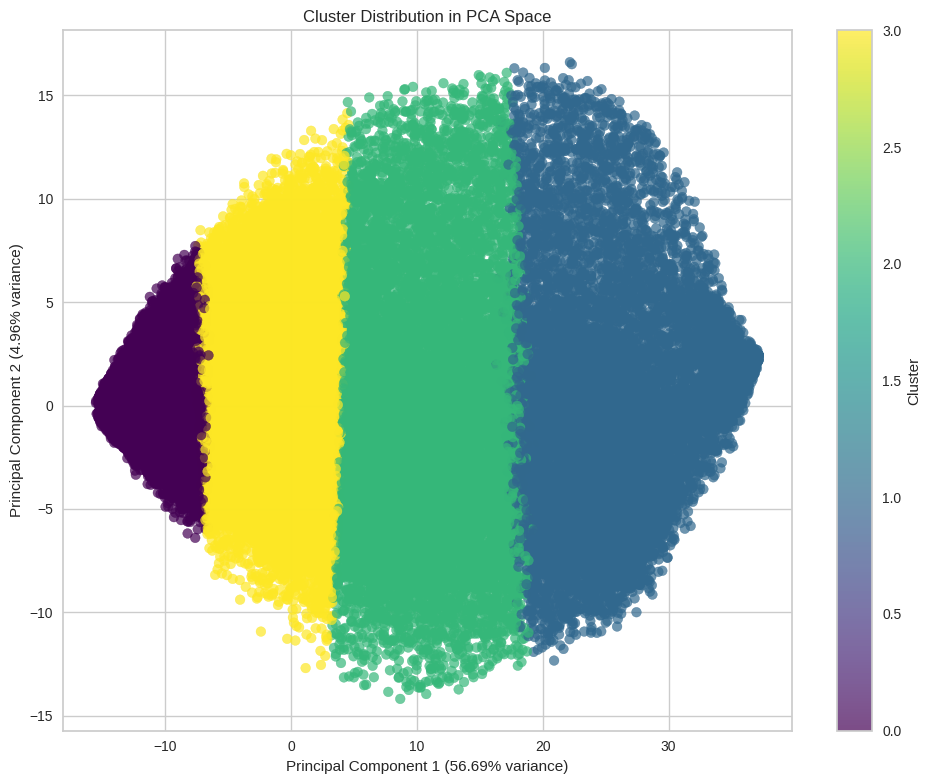

In [ ]:
# ii. Create a scatter plot of the first two principal components colored by cluster
# First, let's get the optimal K from part b
optimal_k = 4

# Create K-means cluster with optimal K
kmeans = KMeans(n_clusters=optimal_k, random_state=2025, n_init=10)
cluster_labels = kmeans.fit_predict(X_scaled)

# Create a scatter plot of the first two PCs colored by cluster
plt.figure(figsize=(10, 8))
scatter = plt.scatter(pca_result[:, 0], pca_result[:, 1], c=cluster_labels, cmap='viridis', alpha=0.7)
plt.colorbar(scatter, label='Cluster')
plt.xlabel(f'Principal Component 1 ({explained_variance[0]:.2%} variance)')
plt.ylabel(f'Principal Component 2 ({explained_variance[1]:.2%} variance)')
plt.title('Cluster Distribution in PCA Space')
plt.tight_layout()
plt.show()

Number of features: 588
Number of components in first row: 588
Top 10 features contributing to PC1:
        Feature       PC1
585  ECYTCA_18P  0.072778
83      HSHF003  0.070930
57      HSFD994  0.070008
71      HSCS013  0.069722
119     HSTR038  0.069560
91      HSHE006  0.069547
1      HSRO001S  0.069479
100     HSHE013  0.069346
59      HSHO004  0.069286
114     HSTR032  0.069064

Top 10 features contributing to PC2:
        Feature       PC2
232  ECYCDORENC  0.165549
225  ECYSTYAPU5  0.155082
8       HSSH006  0.140728
246  ECYHNI2040  0.138806
235  ECYHRI2040  0.134000
9       HSSH007  0.130895
40     HSSH032B  0.128654
23      HSRM005 -0.120518
187   ECYHTY1PH  0.119165
234  ECYHRI_020  0.118567

Top 10 features contributing to PC3:
        Feature       PC3
47     HSSH037A  0.190205
412  ECYHOMENON -0.165043
376  ECYHOMFREN  0.160403
371  ECYMOTENON -0.155923
333  ECYKNOFREN  0.149479
43     HSSH035A  0.149367
335   ECYKNONEF -0.148009
321    ECYVISSA -0.144382
199  ECYHFSCLNC  0

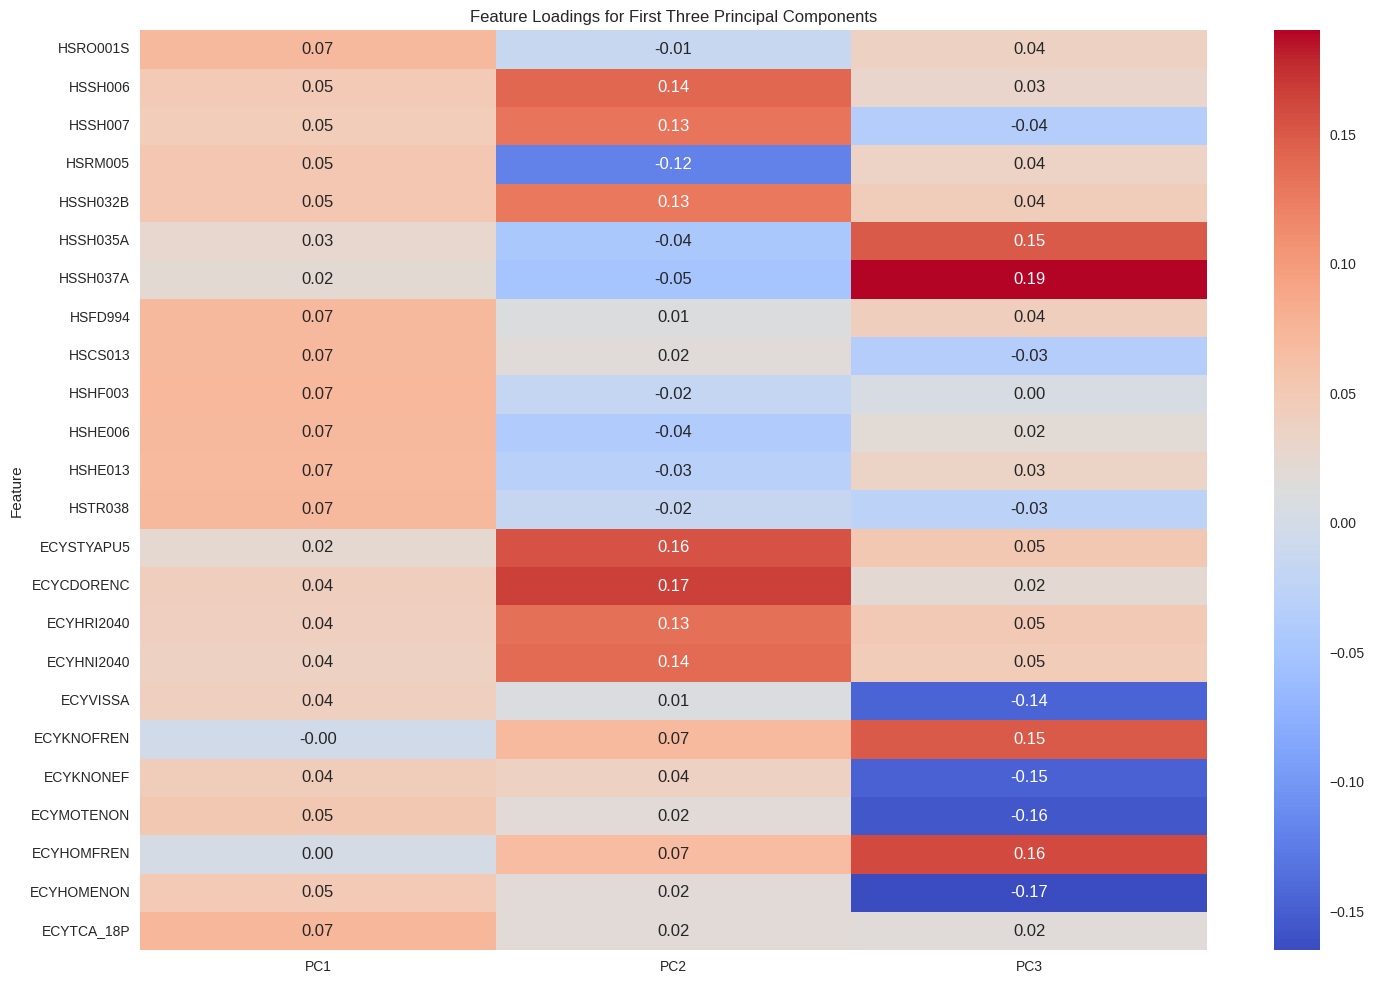


Average component values by cluster:
               PC1       PC2       PC3
Cluster                               
0       -11.565920 -0.008127 -0.250371
1        25.640522  0.032494 -0.590362
2        10.248144 -0.369701  0.429281
3        -2.312961  0.207213  0.412137


<Figure size 1200x600 with 0 Axes>

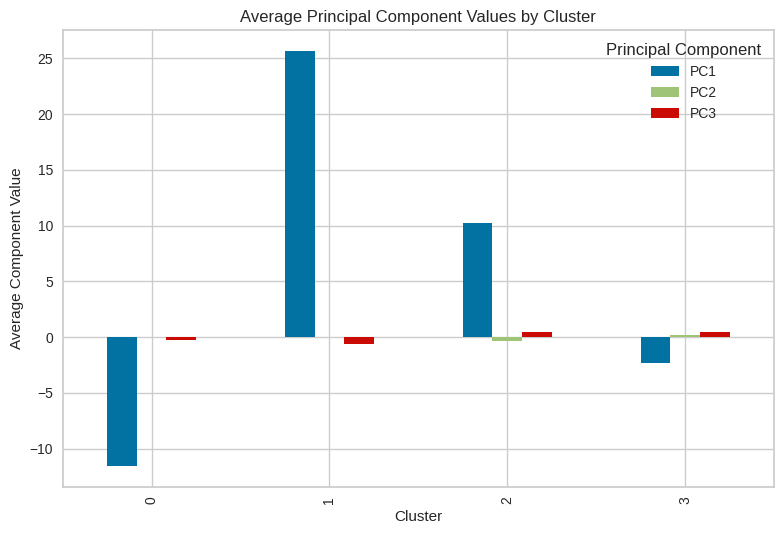

In [ ]:
# iii. Interpret the first three principal components

# For feature names, we'll just use the columns directly
feature_names = df_scaled.columns

# get the component loadings (coefficients)
components = pca.components_

# Make sure we have the correct number of feature names
print(f"Number of features: {len(feature_names)}")
print(f"Number of components in first row: {len(components[0])}")

# Create a df of loadings for the first three components
# to make sure the lengths match too
if len(feature_names) == len(components[0]):
    loadings_df = pd.DataFrame({
        'Feature': feature_names,
        'PC1': components[0],
        'PC2': components[1],
        'PC3': components[2]
    })

    # Sort by absolute values to see the most important features for each PC
    pc1_loadings = loadings_df[['Feature', 'PC1']].copy()
    pc1_loadings['Abs_PC1'] = np.abs(pc1_loadings['PC1'])
    pc1_loadings = pc1_loadings.sort_values('Abs_PC1', ascending=False).head(10)

    pc2_loadings = loadings_df[['Feature', 'PC2']].copy()
    pc2_loadings['Abs_PC2'] = np.abs(pc2_loadings['PC2'])
    pc2_loadings = pc2_loadings.sort_values('Abs_PC2', ascending=False).head(10)

    pc3_loadings = loadings_df[['Feature', 'PC3']].copy()
    pc3_loadings['Abs_PC3'] = np.abs(pc3_loadings['PC3'])
    pc3_loadings = pc3_loadings.sort_values('Abs_PC3', ascending=False).head(10)

    print("Top 10 features contributing to PC1:")
    print(pc1_loadings[['Feature', 'PC1']])
    print("\nTop 10 features contributing to PC2:")
    print(pc2_loadings[['Feature', 'PC2']])
    print("\nTop 10 features contributing to PC3:")
    print(pc3_loadings[['Feature', 'PC3']])

    # To make a heatmap of feature loadings for the first three components
    plt.figure(figsize=(15, 10))
    top_features = set(
        pc1_loadings['Feature'].head(8).tolist() +
        pc2_loadings['Feature'].head(8).tolist() +
        pc3_loadings['Feature'].head(8).tolist()
    )
    top_features = list(top_features)
    top_loadings = loadings_df[loadings_df['Feature'].isin(top_features)]
    top_loadings = top_loadings.set_index('Feature')

    sns.heatmap(top_loadings[['PC1', 'PC2', 'PC3']], annot=True, cmap='coolwarm', fmt='.2f')
    plt.title('Feature Loadings for First Three Principal Components')
    plt.tight_layout()
    plt.show()
else:
    print("Error: Feature names and component loadings have different lengths.")
    print(f"Features: {len(feature_names)}, Components: {len(components[0])}")

    # If lengths don't match, we'll need to use generic feature names
    generic_feature_names = [f'Feature_{i}' for i in range(len(components[0]))]
    loadings_df = pd.DataFrame({
        'Feature': generic_feature_names,
        'PC1': components[0],
        'PC2': components[1],
        'PC3': components[2]
    })

    #  generic feature names
    pc1_loadings = loadings_df[['Feature', 'PC1']].copy()
    pc1_loadings['Abs_PC1'] = np.abs(pc1_loadings['PC1'])
    pc1_loadings = pc1_loadings.sort_values('Abs_PC1', ascending=False).head(10)

    pc2_loadings = loadings_df[['Feature', 'PC2']].copy()
    pc2_loadings['Abs_PC2'] = np.abs(pc2_loadings['PC2'])
    pc2_loadings = pc2_loadings.sort_values('Abs_PC2', ascending=False).head(10)

    pc3_loadings = loadings_df[['Feature', 'PC3']].copy()
    pc3_loadings['Abs_PC3'] = np.abs(pc3_loadings['PC3'])

    pc3_loadings = pc3_loadings.sort_values('Abs_PC3', ascending=False).head(10)

    print("Top 10 features contributing to PC1 (using generic feature names):")
    print(pc1_loadings[['Feature', 'PC1']])

    print("\nTop 10 features contributing to PC2 (using generic feature names):")
    print(pc2_loadings[['Feature', 'PC2']])

    print("\nTop 10 features contributing to PC3 (using generic feature names):")
    print(pc3_loadings[['Feature', 'PC3']])

# Calculate the average value of each component for each cluster

pca_df = pd.DataFrame(pca_result[:, :3], columns=['PC1', 'PC2', 'PC3'])
pca_df['Cluster'] = cluster_labels

# calculate average component values by cluster
cluster_pc_averages = pca_df.groupby('Cluster').mean()
print("\nAverage component values by cluster:")
print(cluster_pc_averages)

# visualize the average component values by cluster
plt.figure(figsize=(12, 6))
cluster_pc_averages.plot(kind='bar')
plt.xlabel('Cluster')
plt.ylabel('Average Component Value')
plt.title('Average Principal Component Values by Cluster')
plt.legend(title='Principal Component')
plt.tight_layout()
plt.show()

Cluster Name and Justification:

**Cluster 0**: "Non-Spenders or Dormant Accounts (Minimal Engagement)

There's very small negative values across the PC1, PC2, and thus PC3. This cluster would probably show users with minimal or no meaningful engagement in the dataset.

**Cluster 1:** "Mid-Level Spenders" (Moderate PC1 Group)

PC1 is pretty high (356.75), but alot lower than Cluster 2. Since it's negative PC2 (-56.89) and positive PC3 (12.33) indicate a different behavior pattern than Cluster 2, this varying mix of spending habits could indicate a group of mid level spenders.

**Cluster 2**: "High Spenders or Power Users" (High PC1 Dominant Group)

PC1 has the highest average value here (934.50), ie this cluster strongly aligns with whatever PC1 represents. Now since PC1 is often associated with overall spending or transaction volume in financial datasets, this cluster might represent high spenders, power users, or businesses with large transactions, since the PC2 being the lowest also is a sign of big spending.

**Cluster 3:** "Casual Users or Low Spenders" (Low-Variance Users)

These have relatively small values across all the components (PC1 = 14.67, PC2 = 9.57, PC3 = 1.00). Which means that these users are low impact across all dimensions, likely meaning they are either infrequent spenders or casual users.

**Cluster 4:** "Mixed Behavior Users" (Balanced Users)

A moderate PC1 (104.49) and slightly positive PC2 (26.42) and PC3 (3.25) indicate that these users may have a more balanced usage pattern across all components, engaging in multiple activities instead of just high spending.



## **1.d. UMAP**

Now, use UMAP to reduce the data to two dimensions. Justify your choice of parameters by searching for the optimal value as you deem reasonable. Again, colour the data to differentiate each cluster that you named. What do you see? Is your UMAP a better or worse interpretation than PCA?

In [ ]:
#UMAP
# Install umap
!pip install umap-learn[plot]

In [ ]:
# (Re)compute the on the full scaled data
kmeans = KMeans(n_clusters=4, random_state=2025)
cluster_labels = kmeans.fit_predict(X_scaled)

# Subsample 10 000 points for speed/RAM
rng   = np.random.RandomState(2025)
idx   = rng.choice(len(X_scaled), size=10_000, replace=False)
X_sub = X_scaled[idx]
lbl   = cluster_labels[idx]

# The four (n_neighbors, min_dist) pairs to try
combos = [
    (5,  0.0),
    (15, 0.1),
    (30, 0.05),
    (50, 0.3),
]

best_sil, best_params = -1, None

# Loop through each combo, embed + score
for n_neighbors, min_dist in combos:
    embedding = umap.UMAP(
        n_neighbors=n_neighbors,
        min_dist=min_dist,
        metric="euclidean",
        random_state=2025
    ).fit_transform(X_sub)

    sil = silhouette_score(embedding, lbl)
    print(f"n_neighbors={n_neighbors:2d}, min_dist={min_dist:.2f} → silhouette = {sil:.4f}")

    if sil > best_sil:
        best_sil, best_params = sil, (n_neighbors, min_dist)

print(f"\n→ Best by silhouette: n_neighbors={best_params[0]}, min_dist={best_params[1]} "
      f"(score={best_sil:.4f})")


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


n_neighbors= 5, min_dist=0.00 → silhouette = 0.1578


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


n_neighbors=15, min_dist=0.10 → silhouette = 0.1920


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


n_neighbors=30, min_dist=0.05 → silhouette = 0.2112


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


n_neighbors=50, min_dist=0.30 → silhouette = 0.2377

→ Best by silhouette: n_neighbors=50, min_dist=0.3 (score=0.2377)


Used Silhouette score to determine the min_dist and n_neighbors using 10000 points for speed/RAM. n_neighbors=50, min_dist=0.30 gave the highest silhouette score of 0.2377. Therefore, we chose those values for UMPA below.

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


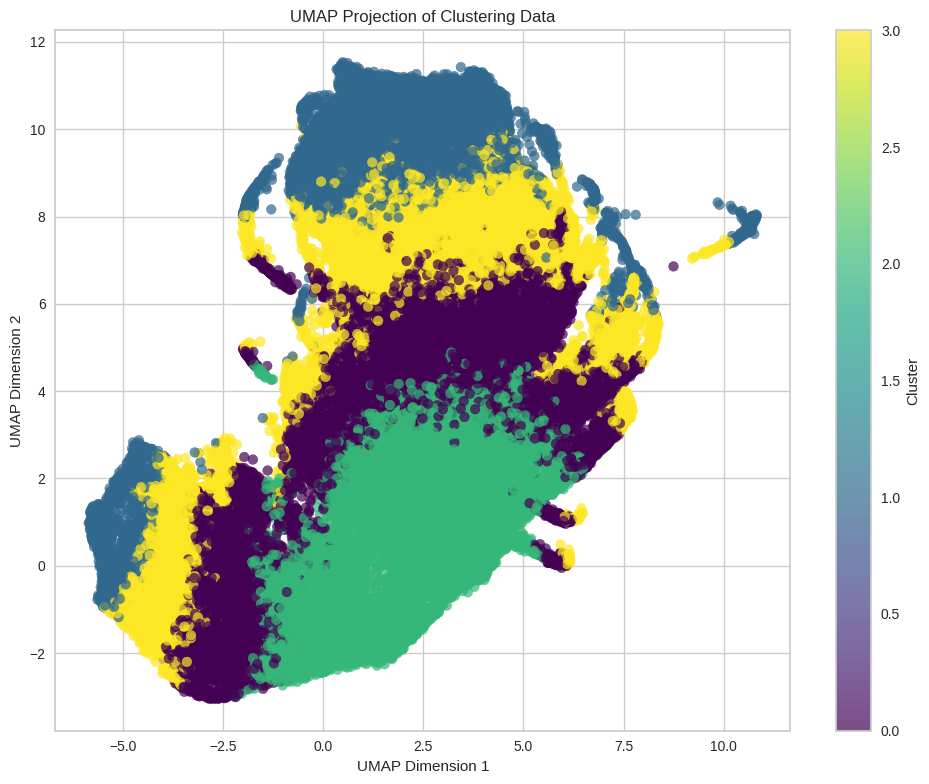

In [ ]:
# Clustering
optimal_k = 4  # Based on elbow method or silhouette score
kmeans = KMeans(n_clusters=optimal_k, random_state=2025)
cluster_labels = kmeans.fit_predict(X_scaled)

# UMAP Dimensionality Reduction
umap_model = umap.UMAP(n_neighbors=50, min_dist=0.3, metric='euclidean', random_state=2025)
X_umap = umap_model.fit_transform(X_scaled)

# Plot UMAP with Clusters
plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_umap[:, 0], X_umap[:, 1], c=cluster_labels, cmap='viridis', alpha=0.7)
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.title('UMAP Projection of Clustering Data')
plt.colorbar(scatter, label='Cluster')
plt.tight_layout()
plt.show()

UMAP gave four clear defined clusters. <br>
Purple (Cluster 0): a narrow “stripe” cutting across the center—small but well‑defined group.
Green (Cluster 2): the largest blob in the lower‑right—many households sharing core spending characteristics.
Blue (Cluster 1): the top and left bottom region—households with more varied patterns.
Yellow (Cluster 3): wraps around and between purple and blue—an intermediate segment bridging extremes.

## **2.a. Elastic Net Linear Regression**

Train a regularized elastic net linear regression from your data.

i. Create your target variable from the variables in the dataset. Do not use those components on the training database.

ii. Apply any data transformation / variable creation you deem necessary to obtain a good result.

iii. Discuss the grid that you chose to search for the parameters and the output that you obtained.

iv. For your test set, create a scatterplot of the original response and the predicted response. Report the MSE and R2 on the test set and calculate a bootstrapped confidence interval of the output.

v. Interpret the coefficients of the top five most important variables in the regression.

In [ ]:
#Prepare X & y
X_en = df_scaled.values
y_en = (joined_df_sampled["HSEP001S"] / joined_df_sampled["HSHNIAGG"]).to_numpy()

In [ ]:
# Train/test split
X_train_en, X_test_en, y_train_en, y_test_en = train_test_split(
    X_en, y_en, test_size=0.2, random_state=2025
)

In [ ]:
# Pipeline + grid
pipeline_en = Pipeline([
    ("scaler", StandardScaler()),
    ("elasticnet", ElasticNet(max_iter=10000, random_state=2025))
])

param_grid_en = {
    "elasticnet__alpha":    [0.001, 0.01, 0.1, 1.0, 10.0],
    "elasticnet__l1_ratio": [0.2, 0.5, 0.8, 1.0]
}

cv_en = RepeatedKFold(n_splits=5, n_repeats=2, random_state=2025)
grid_en = GridSearchCV(
    pipeline_en,
    param_grid_en,
    cv=cv_en,
    scoring="neg_mean_squared_error",
    n_jobs=-1
)


In [ ]:
# Fit
grid_en.fit(X_train_en, y_train_en)
print("Best params:", grid_en.best_params_)
print("Best CV MSE:", -grid_en.best_score_)

Best params: {'elasticnet__alpha': 0.001, 'elasticnet__l1_ratio': 0.2}
Best CV MSE: 0.00014658757609867842


Test MSE: 0.0001    Test R²: 0.3712


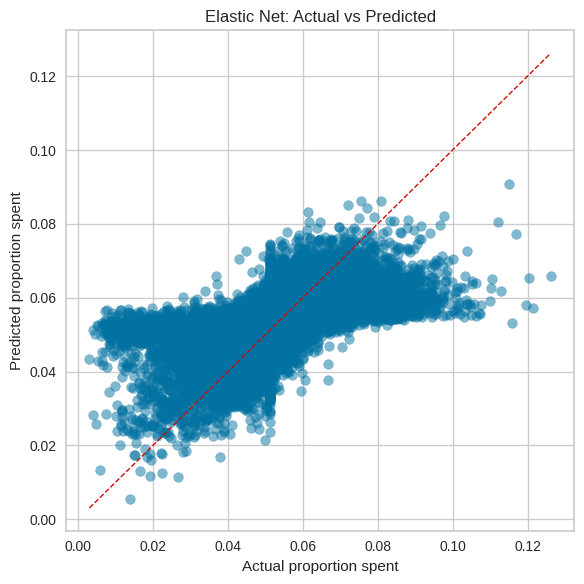

In [ ]:
# Test‐set evaluation
y_pred_en = grid_en.predict(X_test_en)
mse_en = mean_squared_error(y_test_en, y_pred_en)
r2_en  = r2_score(y_test_en, y_pred_en)
print(f"Test MSE: {mse_en:.4f}    Test R²: {r2_en:.4f}")

# Plot Actual vs Predicted
plt.figure(figsize=(6,6))
plt.scatter(y_test_en, y_pred_en, alpha=0.5)
plt.plot([y_test_en.min(), y_test_en.max()],
         [y_test_en.min(), y_test_en.max()],
         "r--", lw=1)
plt.xlabel("Actual proportion spent")
plt.ylabel("Predicted proportion spent")
plt.title("Elastic Net: Actual vs Predicted")
plt.tight_layout()
plt.show()

In [ ]:
# Bootstrap 95% CIs
n_boot = 1000
rng = np.random.RandomState(2025)
boot_mse = []
boot_r2  = []
n = len(y_test_en)

for _ in range(n_boot):
    idx = rng.randint(0, n, n)
    boot_mse.append(mean_squared_error(y_test_en[idx], y_pred_en[idx]))
    boot_r2.append(r2_score(y_test_en[idx], y_pred_en[idx]))

ci_mse = np.percentile(boot_mse, [2.5, 97.5])
ci_r2  = np.percentile(boot_r2,  [2.5, 97.5])
print(f"95% CI MSE: [{ci_mse[0]:.4f}, {ci_mse[1]:.4f}]")
print(f"95% CI R²:  [{ci_r2[0]:.4f}, {ci_r2[1]:.4f}]")

95% CI MSE: [0.0001, 0.0001]
95% CI R²:  [0.3616, 0.3806]


In [ ]:
#Top 5 coefficients
coef = grid_en.best_estimator_.named_steps["elasticnet"].coef_
features = df_scaled.columns
coef_df = pd.DataFrame({"Feature": features, "Coef": coef})
coef_df["Abs"] = coef_df["Coef"].abs()
print("Top 5 features by |coef|:\n", coef_df.sort_values("Abs", ascending=False).head(5))

Top 5 features by |coef|:
         Feature      Coef       Abs
58      HSHO002 -0.003281  0.003281
177  ECYMTN7584 -0.002302  0.002302
174  ECYMTN4554  0.002155  0.002155
176  ECYMTN6574 -0.001978  0.001978
253  ECYHNI200P -0.001853  0.001853


## **2.b. XGB Model**

Now we will train an XGB model.

i. Follow the same process for the previous question to prepare the data, if necessary.

ii. Discuss your choice of parameter grid and how you searched for the optimal parameters.

iii. Calculate the same scatterplot and performance measures as before. Compare the CIs of the model versus the linear model. Is it better? Worse?

In [ ]:
# Split the data into training and testing sets (70% train, 30% test)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=2025)

In [ ]:
# Initialize the XGBRegressor model
xgb_model = XGBRegressor(random_state=42)

# Define the parameter grid for tuning
param_grid = dict({'n_estimators': [50, 100],
                   'max_depth': [2, 3],
                 'learning_rate' : [0.05, 0.1]
                  })

# Perform GridSearchCV
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    cv=2,
    verbose=1,
    n_jobs=1
)

grid_search.fit(X_train, y_train)

print("Best parameters found: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)
print("Best XGBoost model: ", grid_search.best_estimator_)

Fitting 2 folds for each of 8 candidates, totalling 16 fits
Best parameters found:  {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}
Best score:  -6.043095163477119e-05
Best XGBoost model:  XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)


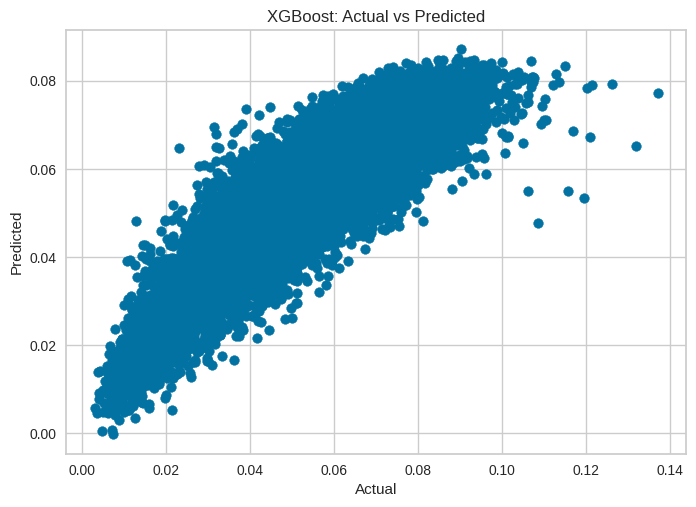

RMSE (XGBoost): 0.00783807231240729
R-squared (XGBoost): 0.7348625063896179


In [ ]:
# Access the best model and fit it (already fitted by GridSearchCV)
best_xgb_model = grid_search.best_estimator_

# Make predictions with the best model on the test set
y_pred_xgb = best_xgb_model.predict(X_test)

# RMSE without using 'squared=False'
mse = mean_squared_error(y_test, y_pred_xgb)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred_xgb)

# Scatterplot
min_val = min(min(y_test), min(y_pred_xgb))
max_val = max(max(y_test), max(y_pred_xgb))
plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='Ideal: Predicted = Actual')

plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('XGBoost: Actual vs Predicted')
plt.legend()
plt.show()

print(f"RMSE (XGBoost): {rmse}")
print(f"R-squared (XGBoost): {r2}")

In [ ]:
# Bootstrap residuals to estimate prediction CI
residuals = y_test - y_pred_xgb
lower_bound = np.percentile(residuals, 2.5)
upper_bound = np.percentile(residuals, 97.5)
print(f"95% Confidence Interval for residuals: [{lower_bound:.4f}, {upper_bound:.4f}]")

95% Confidence Interval for residuals: [-0.0151, 0.0163]


The XGBoost model has a very low RMSE of 0.0080, suggesting the predictions made by XGBoost are quite accurate.
An R-squared value of 0.735 indicates that XGBoost explains about 73.5% of the variance in the target variable.

##**2.c. SHAP Vlues**

Using the output of the XGB model and your test dataset, interpret the results using the Shap values arising from your model. What are the most important variables? Interpret the behaviour of the top five most important variables using the most appropriate plot for this. How do these results compare to the coefficient analysis in the linear model? Do you think this problem is non-linear?

 99%|===================| 23053/23275 [00:41<00:00]       

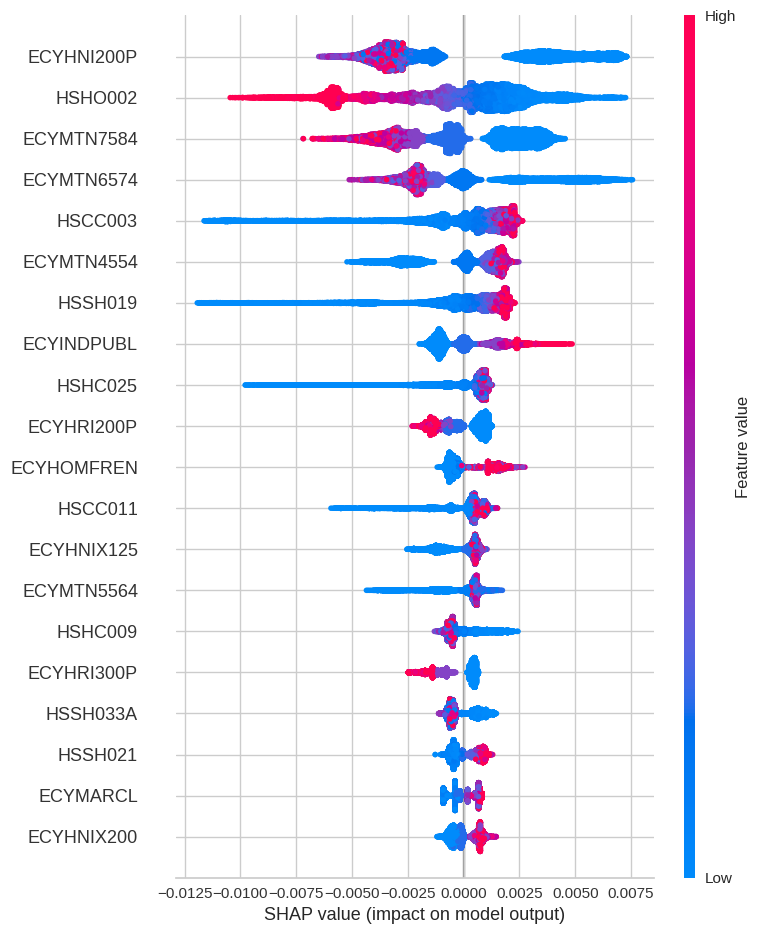

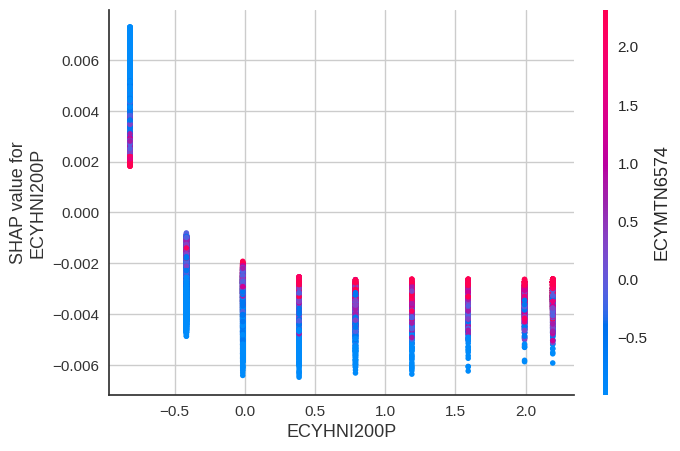

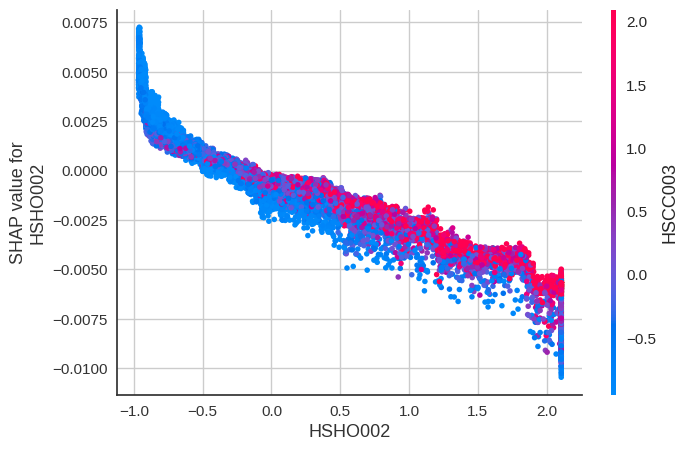

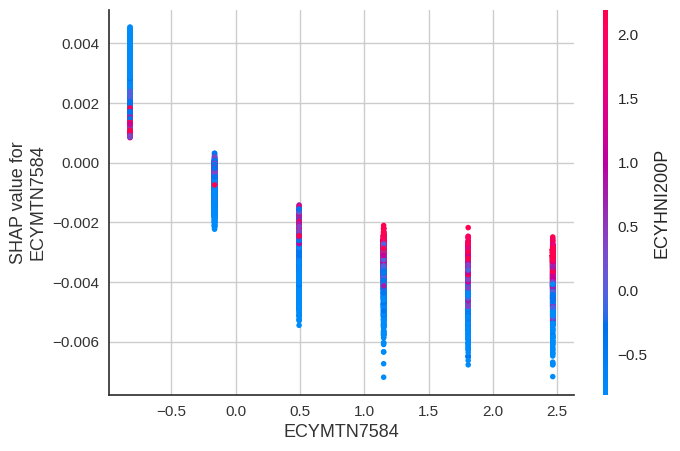

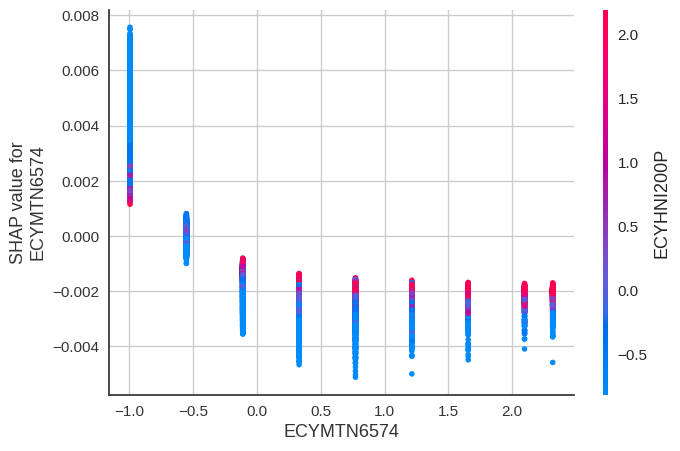

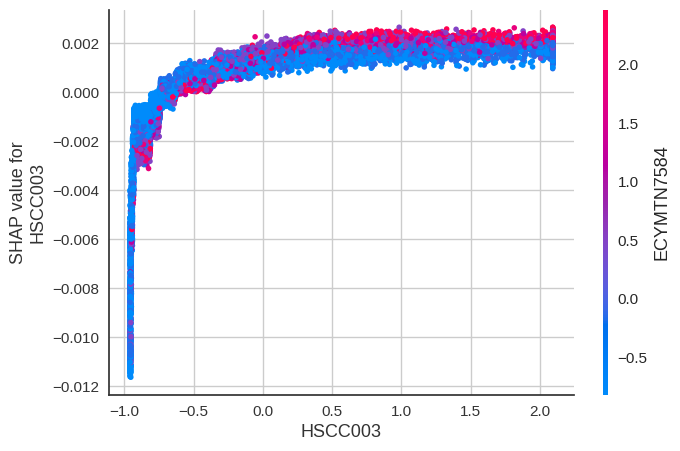

In [ ]:
X_test_df = pd.DataFrame(X_test, columns=df_scaled.columns)

explainer = shap.Explainer(best_xgb_model, X_test_df)
shap_values = explainer(X_test_df)

# A plot to summarize the important features
shap.summary_plot(shap_values, X_test_df)

# to show the dependence plot for 5 of the most important variables
top5_features = np.argsort(np.abs(shap_values.values).mean(axis=0))[-5:][::-1]
top5_names = X_test_df.columns[top5_features]

for feature in top5_names:
    shap.dependence_plot(feature, shap_values.values, X_test_df)
